# FactoryML

## Hardware

In [15]:
!nvidia-smi

Sun Feb 23 01:24:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 570.86.16      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P4             10W /  115W |    6300MiB /   8188MiB |     29%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports

In [16]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import pandas as pd
import numpy as np
import keras
print("Keras version: ", keras.__version__)
from keras import layers
from matplotlib import pyplot as plt

Keras version:  3.8.0


## Loading data

### Columns

For furnace:
- DateTime - timestamp of the data
- ActivePower - power draw of the furnace
- ReactivePower - reactive power draw of the furnace
- MetalOutputIntensity - intensity of the metal output
- FurnacePodTemparature - temperature of the furnace pod
- FurnaceBathTemperature - temperature of the furnace bath
- PowerSetpoint - power setpoint of the furnace

For specific electrodes:
- ReleaseAmountA - how much graphite electrode is exposed to the furnace for electrode A
- ReleaseAmountB - how much graphite electrode is exposed to the furnace for electrode B
- ReleaseAmountC - how much graphite electrode is exposed to the furnace for electrode C
- UpperRingRaiseA - how much the upper ring is raised for electrode A
- UpperRingRaiseB - how much the upper ring is raised for electrode B
- UpperRingRaiseC - how much the upper ring is raised for electrode C
- UpperRingReleaseA - how much the upper ring is released for electrode A
- UpperRingReleaseB - how much the upper ring is released for electrode B
- UpperRingReleaseC - how much the upper ring is released for electrode C
- GasPressureUnderFurnaceA - gas pressure under the furnace for electrode A
- GasPressureUnderFurnaceB - gas pressure under the furnace for electrode B
- GasPressureUnderFurnaceC - gas pressure under the furnace for electrode C
- PowerA - power draw of the furnace for electrode A
- PowerB - power draw of the furnace for electrode B
- PowerC - power draw of the furnace for electrode C
- HighVoltageA - high voltage on electrode A
- HighVoltageB - high voltage on electrode B
- HighVoltageC - high voltage on electrode C
- LowerRingReleaseA - how much the lower ring is released for electrode A
- LowerRingReleaseB - how much the lower ring is released for electrode B
- LowerRingReleaseC - how much the lower ring is released for electrode C
- VentialtionValveForMantelA - ventilation valve of mantel for electrode A
- VentialtionValveForMantelB - ventilation valve of mantel for electrode B
- VentialtionValveForMantelC - ventilation valve of mantel for electrode C
- VoltageStepA - voltage step for electrode A
- VoltageStepB - voltage step for electrode B
- VoltageStepC - voltage step for electrode C
- CurrentHolderPositionA - current holder position for electrode A
- CurrentHolderPositionB - current holder position for electrode B
- CurrentHolderPositionC - current holder position for electrode C
- HolderModeA - holder mode for electrode A (automatic or manual)
- HolderModeB - holder mode for electrode B (automatic or manual)
- HolderModeC - holder mode for electrode C (automatic or manual)
- AirTemperatureMantelA - air temperature for electrode A
- AirTemperatureMantelB - air temperature for electrode B
- AirTemperatureMantelC - air temperature for electrode C

In [17]:
df = pd.read_csv(
    './data/dataset.csv', 
    index_col='DateTime', 
    parse_dates=True)

# decompose datetime to year, month, day, hour, minute, dayofweek
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['dayofweek'] = df.index.dayofweek

df = df.head(1440)
df = df[['CurrentHolderPositionA']]
df.reset_index(drop=True, inplace=True)

df.head()

,CurrentHolderPositionA
0,208.195312
1,208.265625
2,208.687500
3,208.687500
4,208.687500


# Preprocessing

In [18]:
# replace missing values with the median
df.fillna(df.median(), inplace=True)

# normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

## Visualize

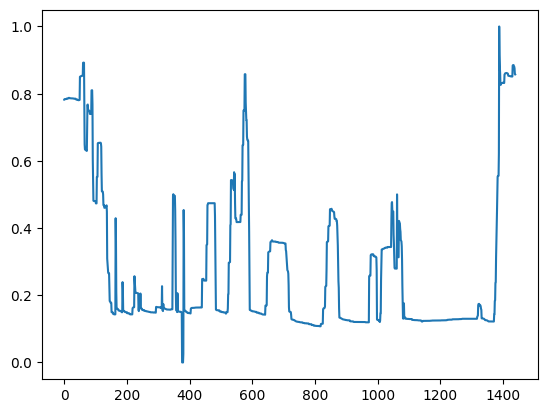

In [19]:
fig, ax = plt.subplots()
df_scaled.plot(legend=False, ax=ax)
plt.show()


# Learning

In [20]:
training_mean = df_scaled.mean()
training_std = df_scaled.std()
df_training_value = (df_scaled - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 1440


In [21]:
from utils import create_sequences

x_train = create_sequences(df_training_value.values)
# fill the missing values with median
x_train = np.nan_to_num(x_train, nan=np.nanmedian(x_train))
print("Training input shape: ", x_train.shape)


Training input shape:  (1241, 200, 1)


In [22]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 100, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 100, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_4              │ (None, 200, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_5              │ (None, 200, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

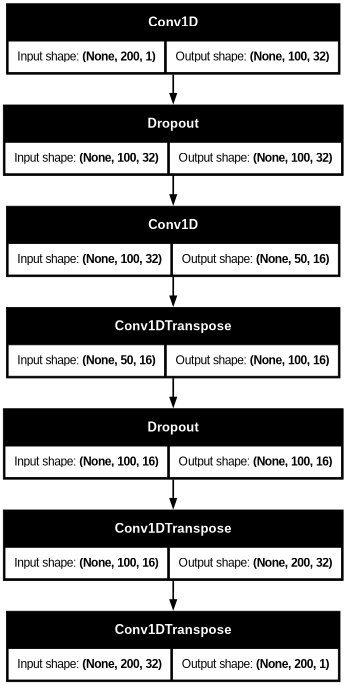

In [33]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

In [24]:
history = model.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=256,
    validation_split=0.1,
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 570ms/step - loss: 0.5245 - val_loss: 0.6821
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4606 - val_loss: 0.4539
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3055 - val_loss: 0.1883
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1443 - val_loss: 0.0585
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0777 - val_loss: 0.0644
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0723 - val_loss: 0.0431
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0556 - val_loss: 0.0570
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0591 - val_loss: 0.0406
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0473 - val_loss: 0.0312
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0455 - val_loss: 0.0301


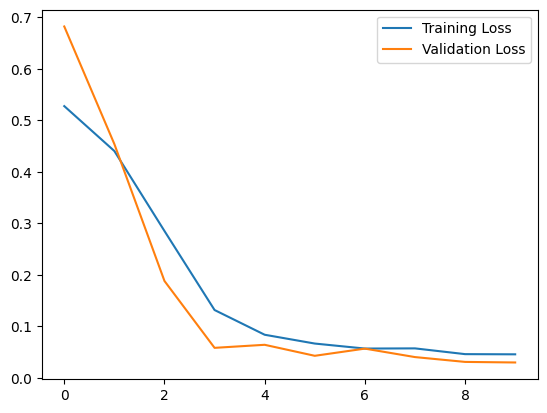

In [25]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


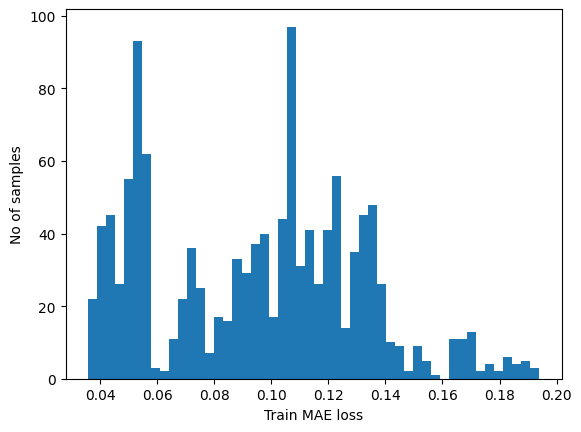

Reconstruction error threshold:  0.1938911145556839


In [26]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

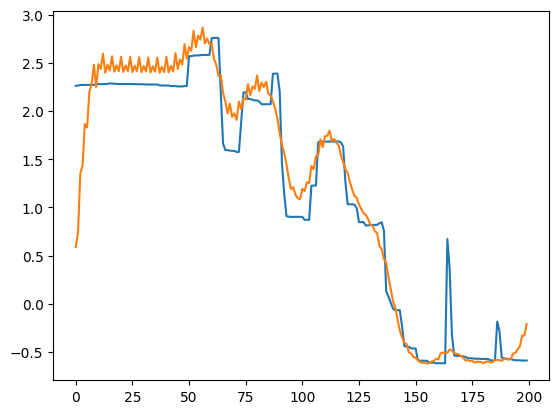

In [27]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [28]:
# export model
model.export('model.tf')

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


Saved artifact at 'model.tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 1), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 200, 1), dtype=tf.float32, name=None)
Captures:
  136478494851728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494857680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494856336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494860176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494860368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494861520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494860944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494862288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494861712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136478494863056: TensorSpec(shape=(), dtype=tf.resource, name=None)
